In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.initializers import Constant
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Conv1D,MaxPooling1D,Dropout,LSTM,Bidirectional,Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('twitter_training.csv',header=None)

In [4]:
df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       74682 non-null  int64 
 1   1       74682 non-null  object
 2   2       74682 non-null  object
 3   3       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [6]:
df['Sentiment']=df[2]
df['Text']=df[3]

In [7]:
df.head()

,0,1,2,3,Sentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
df.drop(columns=[0,1,2,3],axis=1,inplace=True)

In [9]:
df.head()

,Sentiment,Text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  74682 non-null  object
 1   Text       73996 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [11]:
df.isnull().values.any()

True

In [12]:
df.apply(pd.isnull).sum()

Sentiment      0
Text         686
dtype: int64

In [13]:
df.shape

(74682, 2)

In [14]:
df.dropna(subset=['Text'],inplace=True)

In [15]:
df.isnull().sum()

Sentiment    0
Text         0
dtype: int64

In [16]:
df.shape

(73996, 2)

In [17]:
df['Sentiment'].value_counts()

Sentiment
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

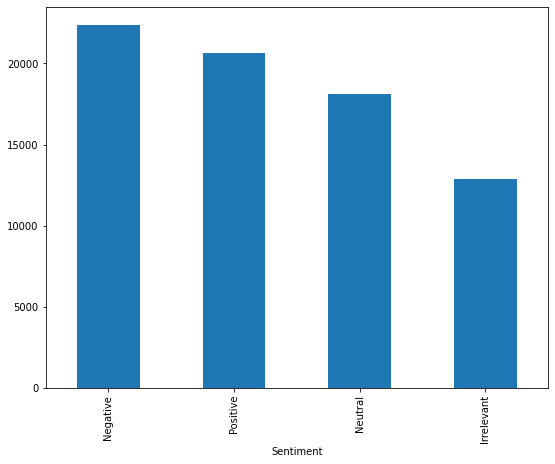

In [18]:
df['Sentiment'].value_counts().plot(kind='bar',figsize=(9,7))
plt.show()

In [19]:
df[df['Sentiment']=='Irrelevant'].shape

(12875, 2)

In [20]:
df_neg=df[df['Sentiment']=='Negative']
df_pos=df[df['Sentiment']=='Positive']
df_neu=df[df['Sentiment']=='Neutral']
df_irr=df[df['Sentiment']=='Irrelevant']

In [21]:
df_neg_n=df_neg.sample(df_irr.shape[0])
df_pos_n=df_pos.sample(df_irr.shape[0])
df_neu_n=df_neu.sample(df_irr.shape[0])

In [22]:
df_neg_n.shape

(12875, 2)

In [23]:
df_pos_n.shape

(12875, 2)

In [24]:
df_neu_n.shape

(12875, 2)

In [25]:
df_irr.shape

(12875, 2)

In [26]:
df_balanced=pd.concat([df_neg_n,df_pos_n,df_neu_n,df_irr])

In [27]:
df_balanced.head()

,Sentiment,Text
30128,Negative,@ PlayApex @ Titanfall - the new top patch for...
15830,Negative,wtf
45347,Negative,"YOUR CAN HECK<unk> T-MOBILE, METRO PCS, VERIZO..."
63310,Negative,5 RhandlerR RhandlerR Thanks for letting every...
63325,Negative,@ EAMaddenNFL


In [28]:
df_balanced[df_balanced['Text']==' ']

,Sentiment,Text
12558,Negative,
42810,Negative,
43680,Negative,
36900,Negative,
48570,Negative,
...,...,...
68166,Irrelevant,
68676,Irrelevant,
69402,Irrelevant,
69660,Irrelevant,


In [29]:
df_balanced=df_balanced[df_balanced['Text']!=' ']

In [30]:
df_balanced.shape

(51373, 2)

In [31]:
df_balanced['Sentiment'].value_counts()

Sentiment
Positive      12853
Negative      12848
Irrelevant    12842
Neutral       12830
Name: count, dtype: int64

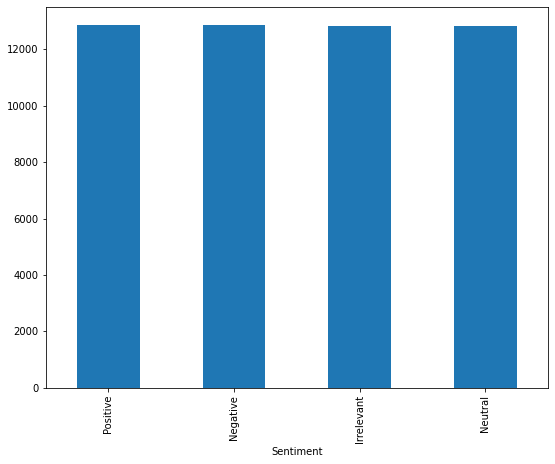

In [32]:
df_balanced['Sentiment'].value_counts().plot(kind='bar',figsize=(9,7))
plt.show()

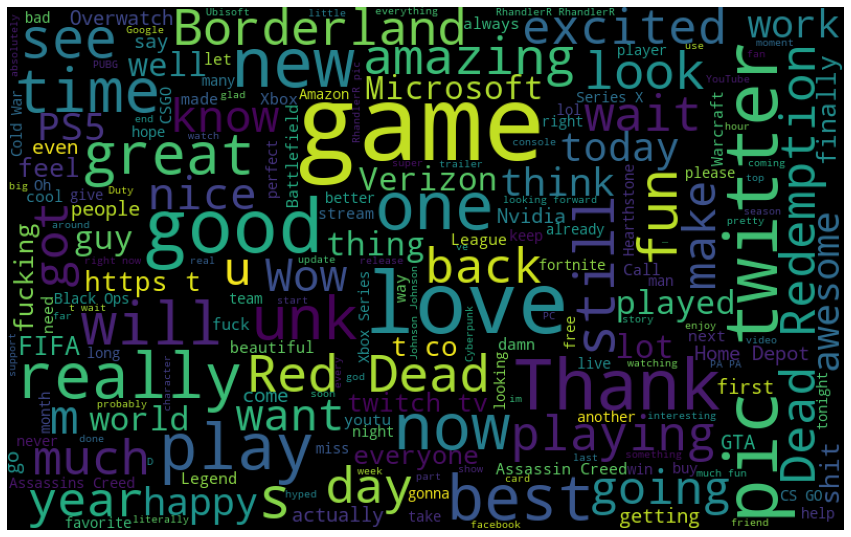

In [33]:
plt.figure(figsize=(15,19))
w_po=' '.join(df_balanced['Text'][df_balanced['Sentiment']=='Positive'].tolist())
wordcloud_po=WordCloud(width=800,height=500,random_state=101,max_font_size=100).generate(w_po)
plt.imshow(wordcloud_po)
plt.axis('off')
plt.show()

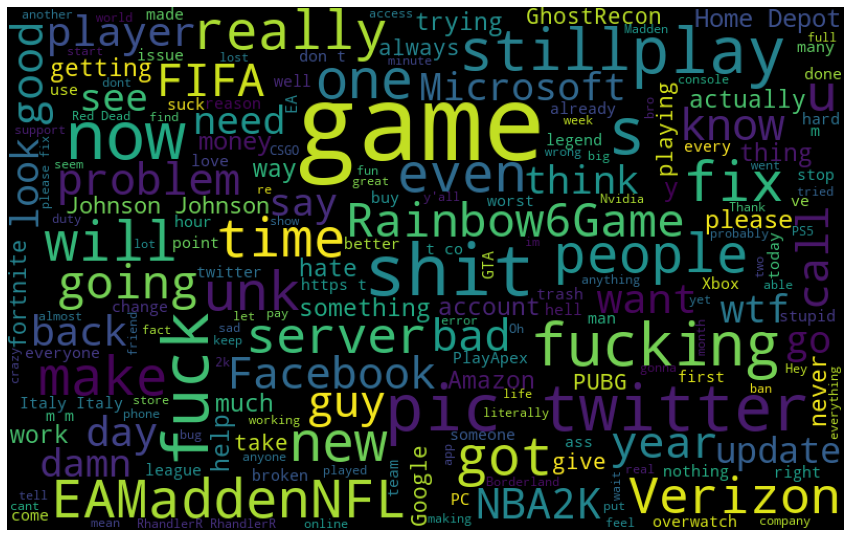

In [34]:
plt.figure(figsize=(15,19))
w_ne=' '.join([text for text in df_balanced['Text'][df_balanced['Sentiment']=='Negative']])
wordcloud_ne=WordCloud(width=800,height=500,random_state=101,max_font_size=100).generate(w_ne)
plt.imshow(wordcloud_ne)
plt.axis('off')
plt.show()

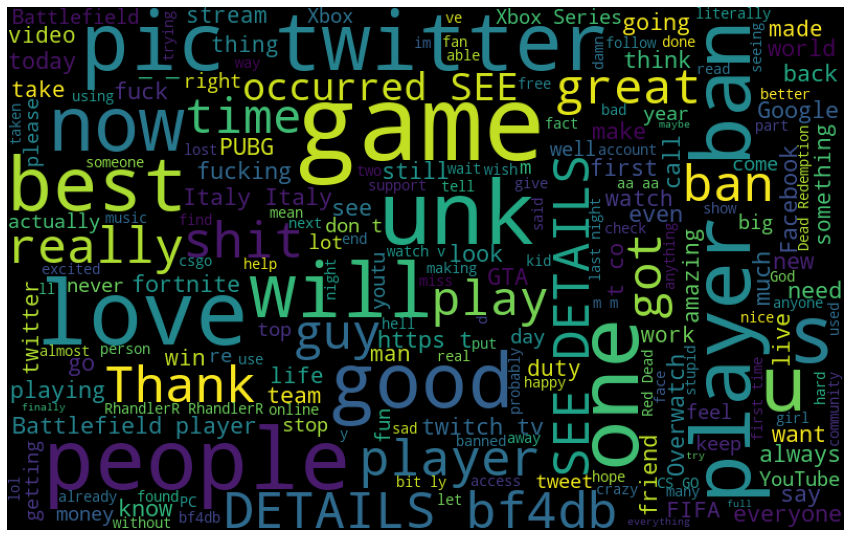

In [35]:
plt.figure(figsize=(15,19))
w_irr=' '.join(df_balanced['Text'][df['Sentiment']=='Irrelevant'].tolist())
wordcloud_irr=WordCloud(width=800,height=500,random_state=101,max_font_size=100).generate(w_irr)
plt.imshow(wordcloud_irr)
plt.axis('off')
plt.show()

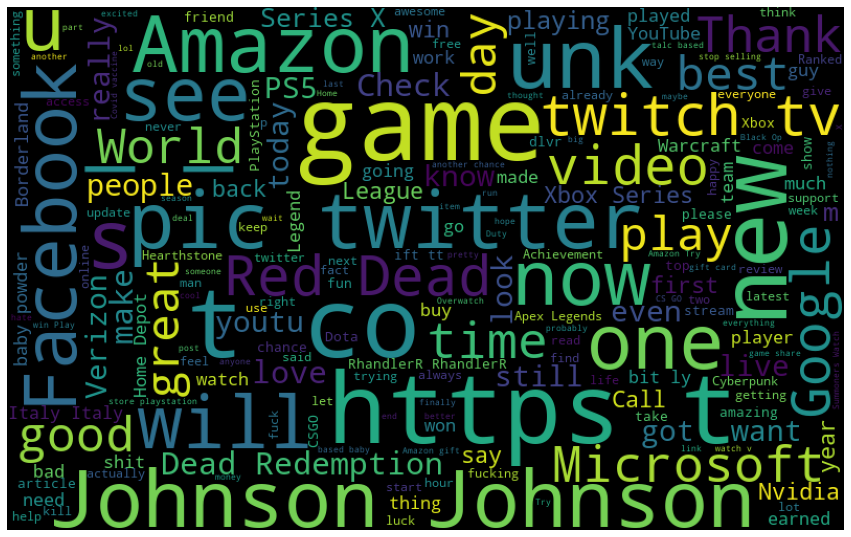

In [36]:
plt.figure(figsize=(15,19))
w_neu=' '.join([text for text in df_balanced['Text'][df_balanced['Sentiment']=='Neutral']])
wordcloud_neu=WordCloud(width=800,height=500,random_state=101,max_font_size=100).generate(w_neu)
plt.imshow(wordcloud_neu)
plt.axis('off')
plt.show()

In [37]:
sw=stopwords.words('english')

In [38]:
lemmatizer=WordNetLemmatizer()

In [39]:
def preprocessing(text):
    text=text.lower()
    text=re.sub('[^a-z]',' ',text)
    text=re.sub('\s+[a-z]\s+',' ',text)
    text=re.sub('\s+',' ',text)
    words=[word for word in text.split() if word not in sw]
    words=[lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [40]:
df_balanced['Preprocessed_text']=df_balanced['Text'].apply(preprocessing)

In [41]:
df_balanced.head()

,Sentiment,Text,Preprocessed_text
30128,Negative,@ PlayApex @ Titanfall - the new top patch for...,playapex titanfall new top patch japanese audi...
15830,Negative,wtf,wtf
45347,Negative,"YOUR CAN HECK<unk> T-MOBILE, METRO PCS, VERIZO...",heck unk mobile metro pc verizon outage america
63310,Negative,5 RhandlerR RhandlerR Thanks for letting every...,rhandlerr rhandlerr thanks letting everyone kn...
63325,Negative,@ EAMaddenNFL,eamaddennfl


In [42]:
df_balanced.drop(columns=['Text'],axis=1,inplace=True)

In [43]:
df_balanced.head()

,Sentiment,Preprocessed_text
30128,Negative,playapex titanfall new top patch japanese audi...
15830,Negative,wtf
45347,Negative,heck unk mobile metro pc verizon outage america
63310,Negative,rhandlerr rhandlerr thanks letting everyone kn...
63325,Negative,eamaddennfl


In [44]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df_balanced['Preprocessed_text'])

In [45]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

25006

In [46]:
def sequence(texts):
    seq=tokenizer.texts_to_sequences(texts)
    pad_seq=pad_sequences(seq,maxlen=99,padding='post')
    return pad_seq

In [47]:
seq_padded=sequence(df_balanced['Preprocessed_text'])

In [48]:
seq_padded

array([[ 210, 2655,   12, ...,    0,    0,    0],
       [ 191,    0,    0, ...,    0,    0,    0],
       [1967,   15,  243, ...,    0,    0,    0],
       ...,
       [   8,  265,  400, ...,    0,    0,    0],
       [   8,  340,  400, ...,    0,    0,    0],
       [  22,  400, 4039, ...,    0,    0,    0]])

In [49]:
embedding_dictionary=dict()
glove_file=open('glove.6B.100d.txt',encoding='utf8')
for line in glove_file:
    record=line.split()
    word=record[0]
    vector=np.asarray(record[1:],dtype='float32')
    embedding_dictionary[word]=vector

In [50]:
embedding_matrix=np.zeros((vocab_size,100))
for word,index in tokenizer.word_index.items():
    embedding_vector=embedding_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index]=embedding_vector

In [51]:
embedding_matrix[1]

array([ 0.062659  ,  0.026003  ,  1.12199998, -0.84122998, -0.56906998,
        0.86677003,  0.99234998, -0.19032   , -0.74225998, -0.29547   ,
        0.037746  , -0.71755999, -0.44891   , -0.65801001,  0.17468999,
        0.50347   ,  0.21268   ,  1.0438    , -0.60034001,  0.48838001,
        0.16955   , -0.070132  , -0.070228  ,  0.50193   ,  1.35430002,
       -0.27193001, -0.16449   ,  0.37399   , -0.14291   ,  0.19645999,
       -0.80925   ,  0.86245   , -0.21179999, -0.074321  ,  0.38521999,
       -0.34136999, -1.2694    ,  0.59966999, -0.84745997, -0.68818003,
        0.68874002, -0.19769   ,  0.20640001, -0.20387   , -0.33651   ,
        0.093972  ,  0.34191999, -0.68138999,  0.61451   , -0.88126999,
       -0.13401   , -0.088989  , -0.098916  ,  0.73404998,  0.33496001,
       -3.10680008, -0.22643   , -0.21568   ,  1.33749998,  1.54719996,
       -1.23430002,  0.42964   , -0.78931999, -0.027462  ,  0.34738001,
        0.17338   ,  0.24975   , -0.010451  , -0.71148998,  0.55

In [52]:
def label_encoder(data):
    le=LabelEncoder()
    return le.fit_transform(data)

In [53]:
y=label_encoder(df_balanced['Sentiment'])

In [54]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [55]:
X=seq_padded

In [56]:
len(X)

51373

In [57]:
len(y)

51373

In [58]:
X_s,y_s=shuffle(X,y)

In [59]:
X_train,X_test,y_train,y_test=train_test_split(X_s,y_s,test_size=0.2,random_state=101,stratify=y_s,shuffle=True)

In [60]:
X_train.shape

(41098, 99)

In [61]:
X_test.shape

(10275, 99)

In [62]:
early_stopping=EarlyStopping(monitor='val_loss')

In [63]:
model=Sequential()
model.add(Embedding(vocab_size,100,embeddings_initializer=Constant(embedding_matrix),trainable=False))
model.add(Conv1D(filters=32,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(4,activation='softmax'))

In [64]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [65]:
history=model.fit(X_train,y_train,epochs=20,validation_split=0.1,callbacks=[early_stopping])

Epoch 1/20
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 71s 57ms/step - accuracy: 0.4146 - loss: 1.2552 - val_accuracy: 0.6182 - val_loss: 0.9404
Epoch 2/20
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 68s 58ms/step - accuracy: 0.6779 - loss: 0.8332 - val_accuracy: 0.7170 - val_loss: 0.7323
Epoch 3/20
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 69s 59ms/step - accuracy: 0.7957 - loss: 0.5535 - val_accuracy: 0.7788 - val_loss: 0.6053
Epoch 4/20
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 71s 61ms/step - accuracy: 0.8504 - loss: 0.4100 - val_accuracy: 0.8097 - val_loss: 0.5573
Epoch 5/20
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 71s 62ms/step - accuracy: 0.8803 - loss: 0.3280 - val_accuracy: 0.8156 - val_loss: 0.5605


In [67]:
y_pred=model.predict(X_test)
y_predict=[np.argmax(i) for i in y_pred]
y_predict[:10]

322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


[1, 2, 1, 1, 3, 2, 0, 3, 0, 0]

In [68]:
y_test[:10]

array([1, 2, 1, 1, 1, 2, 0, 3, 0, 0])

In [70]:
print(classification_report(y_predict,y_test))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2497
           1       0.85      0.80      0.82      2706
           2       0.80      0.84      0.82      2435
           3       0.79      0.77      0.78      2637

    accuracy                           0.82     10275
   macro avg       0.82      0.82      0.82     10275
weighted avg       0.82      0.82      0.82     10275



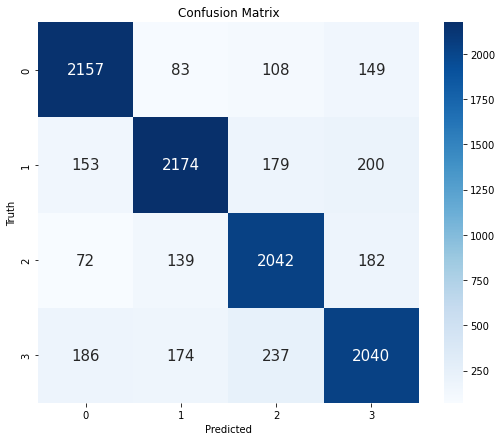

In [73]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(y_predict,y_test),annot=True,square=True,cbar=True,fmt='d',annot_kws={'size':15},cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

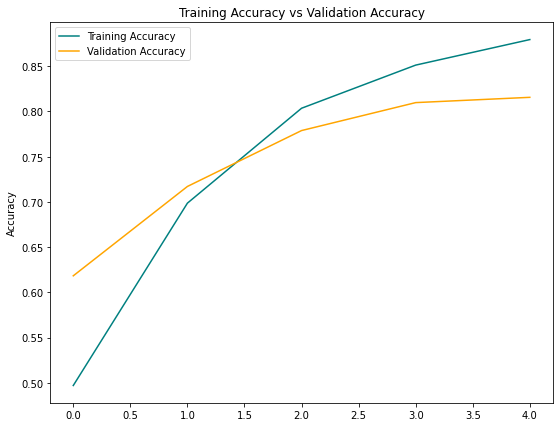

In [74]:
plt.figure(figsize=(9,7))
plt.plot(history.history['accuracy'],color='teal',label='Training Accuracy')
plt.plot(history.history['val_accuracy'],color='orange',label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

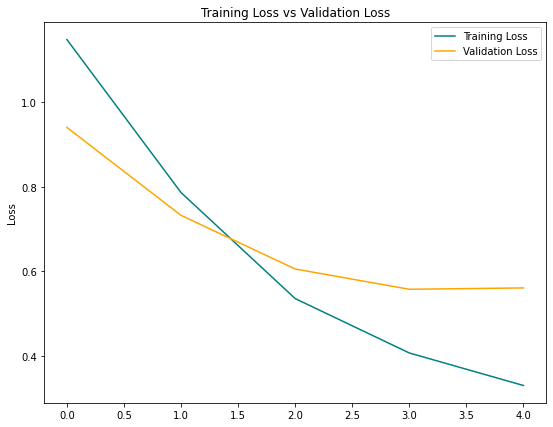

In [75]:
plt.figure(figsize=(9,7))
plt.plot(history.history['loss'],color='teal',label='Training Loss')
plt.plot(history.history['val_loss'],color='orange',label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()